# Neural Modelling exercise 5: Learning to Act
#### Ahmed Eldably

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_maze(maze):
    plt.imshow(maze, cmap='binary')

    # draw thin grid
    for i in range(maze.shape[0]):
        plt.plot([-0.5, maze.shape[1]-0.5], [i-0.5, i-0.5], c='gray', lw=0.5)
    for i in range(maze.shape[1]):
        plt.plot([i-0.5, i-0.5], [-0.5, maze.shape[0]-0.5], c='gray', lw=0.5)

    plt.xticks([])
    plt.yticks([])

In [3]:
def compute_transition_matrix(maze):
    # for a given maze, compute the transition matrix from any state to any other state under a random walk policy
    # (you will need to think of a good way to map any 2D grid coordinates onto a single number for this)

    # create a matrix over all state pairs
    transitions = np.zeros((maze.size, maze.size))
    for i in range(maze.shape[0]):
        for j in range(maze.shape[1]):
            if maze[i, j] == 0:
                state = i * maze.shape[1] + j
                for move in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
                    new_i, new_j = i + move[0], j + move[1]
                    if 0 <= new_i < maze.shape[0] and 0 <= new_j < maze.shape[1] and maze[new_i, new_j] == 0:
                        new_state = new_i * maze.shape[1] + new_j
                        transitions[state, new_state] = 1
    transitions /= transitions.sum(axis=1, keepdims=True)
    transitions[np.isnan(transitions)] = 0  # Handle divide by zero
    return transitions

In [4]:
def analytical_sr(transitions, gamma):
    return np.linalg.inv(np.eye(transitions.shape[0]) - gamma * transitions.T)

## Question 1: Basic Actor-Critic Framework

In [5]:
# define maze
maze = np.zeros((9, 13))

# place walls
maze[2, 6:10] = 1
maze[-3, 6:10] = 1
maze[2:-3, 6] = 1

# define start
start = (5, 7)

# define goal (we abuse function scoping a bit here, later we will change the goal, which will automatically change the goal in our actor critic as well)
goal = (1, 1)
goal_state = goal[0]*maze.shape[1] + goal[1]
goal_value = 10


In [6]:
def softmax(x):
    max_x = np.max(x)
    exps = np.exp(x - max_x) 
    total = np.sum(exps)
    if total == 0:  # Prevent division by zero
        return np.ones_like(exps) / len(exps)
    return exps / total


In [7]:
def normal_start():
    # suggested encoding of 2D location onto states
    state = start[0]*maze.shape[1] + start[1]
    return state

In [8]:
def step(state, action):
    """Simulates taking an action in the maze."""
    x, y = state
    if action == 0 and x > 0 and maze[x - 1, y] == 0:  # Move up
        x -= 1
    elif action == 1 and x < maze.shape[0] - 1 and maze[x + 1, y] == 0:  # Move down
        x += 1
    elif action == 2 and y > 0 and maze[x, y - 1] == 0:  # Move left
        y -= 1
    elif action == 3 and y < maze.shape[1] - 1 and maze[x, y + 1] == 0:  # Move right
        y += 1
    return x, y

In [9]:
def is_goal(state):
    return state == goal

In [10]:
def actor_critic(state_representation, n_steps, alpha, gamma, n_episodes, update_sr=False, start_func=lambda: start[0] * maze.shape[1] + start[1], v_init=0):
    n_states, _ = state_representation.shape
    M = np.zeros((n_states, 4))  # Action propensities
    V_weights = np.ones(n_states) * v_init  # Initialize weights
    earned_rewards = []

    sr_matrix = np.copy(state_representation)  # Initialize SR

    for episode in range(n_episodes):
        state = start_func()  # Start from random or fixed position
        trajectory = []  # Track visited states
        total_reward = 0
        discount = 1

        for _ in range(n_steps):
            s_vector = sr_matrix[state]  # Use current SR row for state
            action_probs = softmax(M[state])

            # Handle invalid action probabilities
            if np.isnan(action_probs).any():
                action_probs = np.ones(4) / 4  # Default to uniform probabilities

            action = np.random.choice(4, p=action_probs)

            # Compute next state
            next_state_coords = (
                (state // maze.shape[1]) + (action == 1) - (action == 0),
                (state % maze.shape[1]) + (action == 3) - (action == 2),
            )
            if (
                0 <= next_state_coords[0] < maze.shape[0] and
                0 <= next_state_coords[1] < maze.shape[1] and
                maze[next_state_coords] == 0
            ):
                next_state = next_state_coords[0] * maze.shape[1] + next_state_coords[1]
            else:
                next_state = state

            trajectory.append(state)

            reward = goal_value if next_state == goal_state else 0
            total_reward += discount * reward

            # TD Error and updates
            next_value = np.dot(sr_matrix[next_state], V_weights)
            current_value = np.dot(s_vector, V_weights)
            td_error = reward + gamma * next_value - current_value

            M[state, action] += alpha * td_error
            V_weights += alpha * td_error * s_vector

            state = next_state
            if state == goal_state:
                break

            discount *= gamma

        earned_rewards.append(total_reward)

        # Update SR dynamically
        if update_sr:
            sr_matrix = learn_from_traj(sr_matrix, trajectory, gamma=gamma, alpha=alpha)
            sr_matrix[np.isnan(sr_matrix)] = 0  # Replace NaNs with 0
            sr_matrix[np.isinf(sr_matrix)] = 0  # Replace infinities with 0

    # Return three values if update_sr=False, otherwise four
    if update_sr:
        return M, V_weights, earned_rewards, sr_matrix
    else:
        return M, V_weights, earned_rewards


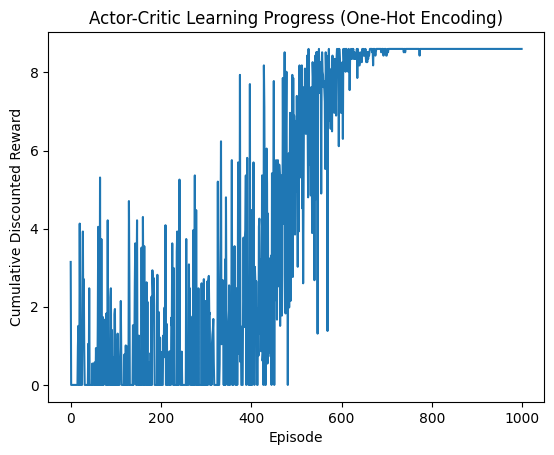

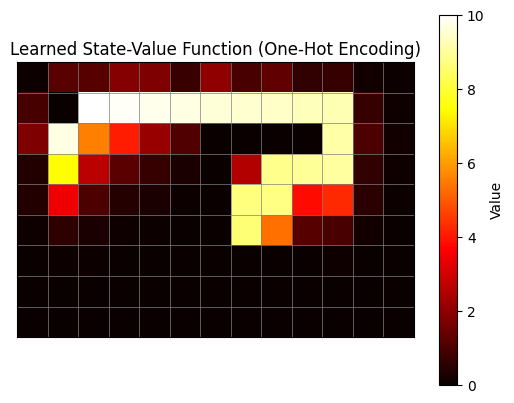

In [11]:
# One-hot state representation
one_hot_representation = np.eye(maze.size)

# Static SR or One-Hot Representation
_, V_weights_static, earned_rewards_static = actor_critic(
    state_representation=one_hot_representation, 
    n_steps=300, 
    alpha=0.05, 
    gamma=0.99, 
    n_episodes=1000,
    update_sr=False
)

# Plot learning curve
plt.plot(earned_rewards_static)
plt.xlabel("Episode")
plt.ylabel("Cumulative Discounted Reward")
plt.title("Actor-Critic Learning Progress (One-Hot Encoding)")
plt.show()

# Plot value function heatmap
plot_maze(maze)
plt.imshow(V_weights_static.reshape(maze.shape), cmap='hot')
plt.title("Learned State-Value Function (One-Hot Encoding)")
plt.colorbar(label="Value")
plt.show()

#### Results:
1. **Learning Curve**:
   The learning curve tracks cumulative discounted rewards over 1000 episodes. The model exhibits high variability in early episodes due to exploration but stabilizes after ~600 episodes, indicating successful learning of the optimal policy.

2. **State-Value Function Heatmap**:
   The heatmap of ( `V(s)` shows a gradient of values leading to the goal state at `(1, 1)`. States closer to the goal have higher values, reflecting the model's learned policy.


## Question 2: Successor Representation (SR)

In [13]:
def compute_sr_analytical(transitions, gamma=0.8):
    identity = np.eye(transitions.shape[0])
    return np.linalg.inv(identity - gamma * transitions.T)

i, j = start
# compute the SR for all states, based on the transition matrix
# note that we use a lower discounting here, to keep the SR more local

transitions = compute_transition_matrix(maze)
successor_representation = compute_sr_analytical(transitions)

/var/folders/76/g6ys7mkj75zg7zyn8m093rk40000gn/T/ipykernel_32983/669196901.py:16: RuntimeWarning: invalid value encountered in divide
  transitions /= transitions.sum(axis=1, keepdims=True)


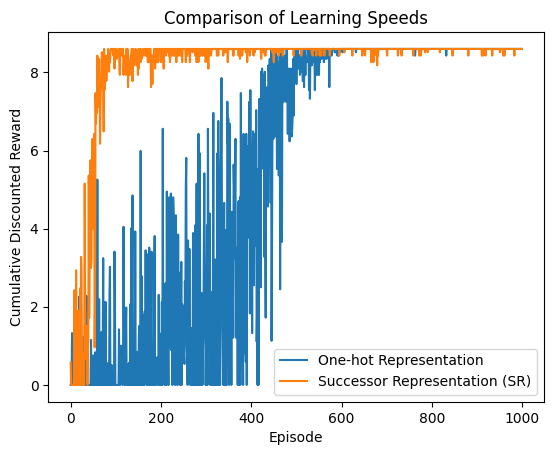

In [14]:
# Compare actor-critic with one-hot vs SR representation
earned_rewards_one_hot = actor_critic(
    one_hot_representation, 
    n_steps=300, 
    alpha=0.05, 
    gamma=0.99, 
    n_episodes=1000
)[2]

earned_rewards_sr = actor_critic(
    successor_representation, 
    n_steps=300, 
    alpha=0.05, 
    gamma=0.99, 
    n_episodes=1000
)[2]

# Plot comparison of learning curves
plt.plot(earned_rewards_one_hot, label="One-hot Representation")
plt.plot(earned_rewards_sr, label="Successor Representation (SR)")
plt.xlabel("Episode")
plt.ylabel("Cumulative Discounted Reward")
plt.title("Comparison of Learning Speeds")
plt.legend()
plt.show()


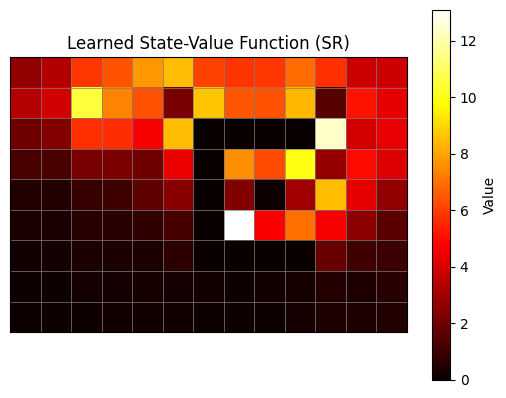

In [15]:
# Visualize the learned value function for SR
_, V_weights_sr, _ = actor_critic(
    successor_representation, 
    n_steps=300, 
    alpha=0.05, 
    gamma=0.99, 
    n_episodes=1000
)

plot_maze(maze)
plt.imshow(V_weights_sr.reshape(maze.shape), cmap="hot")
plt.title("Learned State-Value Function (SR)")
plt.colorbar(label='Value')
plt.show()


### Question 2: Incorporating Successor Representation (SR)

To enhance learning performance, the actor-critic framework was modified to use the Successor Representation (SR) as the state representation. The SR was computed analytically using:

$$
SR = (\mathbb{I} - \gamma \cdot T)^{-1}
$$

where \( T \) is the transition matrix, and $\gamma = 0.8 \$ controls discounting to keep the SR local.

#### Results:
1. **Comparison of Learning Speeds**:
   The learning curve demonstrates the advantage of SR over one-hot encoding. The SR representation achieves optimal cumulative rewards within ~200 episodes, whereas the one-hot representation requires ~600 episodes to converge.

2. **State-Value Function Heatmap**:
   The learned `V(s)` values based on SR are visualized as a heatmap. The values are highest near the goal state `(1, 1)`, indicating optimal navigation.


## Question 3: Dynamic SR Updates

In [16]:
def learn_from_traj(succ_repr, trajectory, gamma=0.98, alpha=0.05):
    """
    Updates the Successor Representation (SR) based on a trajectory.
    Parameters:
        - succ_repr: Current SR matrix (2D: n_states x n_states).
        - trajectory: List of visited states in an episode.
        - gamma: Discount factor.
        - alpha: Learning rate for SR updates.
    Returns:
        - Updated SR matrix.
    """
    observed = np.zeros_like(succ_repr[0])  # Observed SR for the first state
    for i, state in enumerate(trajectory):
        observed[state] += gamma ** i
    starting_state = trajectory[0]
    succ_repr[starting_state] += alpha * (observed - succ_repr[starting_state])
    return succ_repr


In [17]:
def random_start():
    """Returns a random valid starting state in the maze."""
    valid_states = np.where(maze.flatten() == 0)[0]
    return np.random.choice(valid_states)


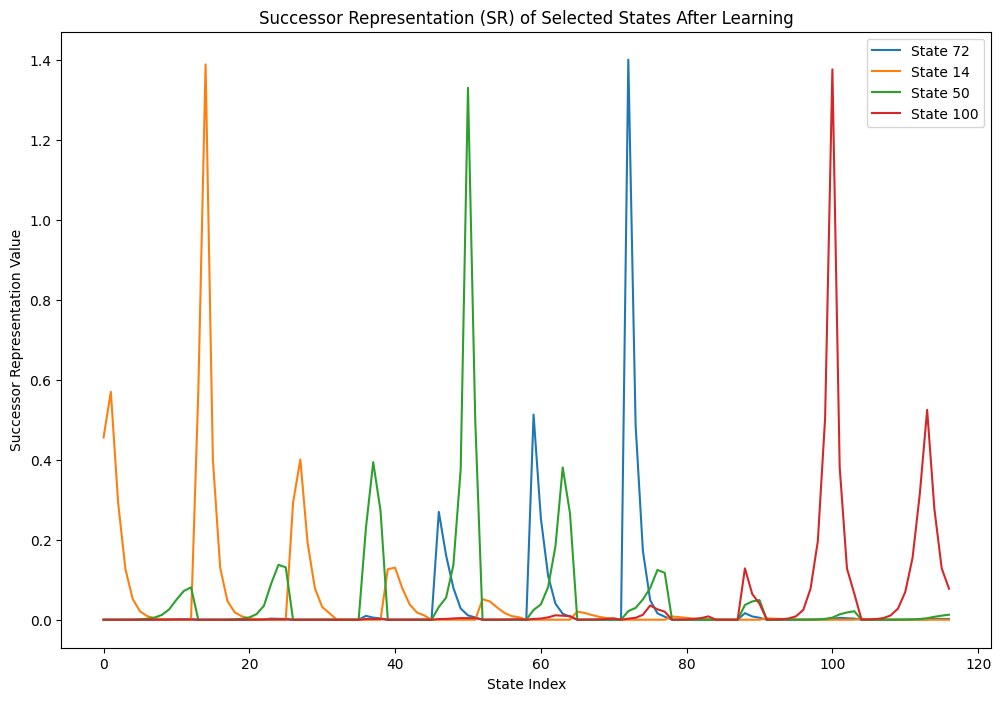

In [18]:
# Plotting the SR of selected states after dynamic SR learning

# Selected states for visualization
start_state = start[0] * maze.shape[1] + start[1]
selected_states = [
    start_state,
    goal_state,                           
    50,  
    100 
]

# Plot SR for the selected states
plt.figure(figsize=(12, 8))
for state in selected_states:
    plt.plot(successor_representation[state], label=f"State {state}")

plt.xlabel("State Index")
plt.ylabel("Successor Representation Value")
plt.title("Successor Representation (SR) of Selected States After Learning")
plt.legend()
plt.show()


/var/folders/76/g6ys7mkj75zg7zyn8m093rk40000gn/T/ipykernel_32983/2336624930.py:50: RuntimeWarning: overflow encountered in multiply
  V_weights += alpha * td_error * s_vector
/var/folders/76/g6ys7mkj75zg7zyn8m093rk40000gn/T/ipykernel_32983/2336624930.py:47: RuntimeWarning: invalid value encountered in scalar subtract
  td_error = reward + gamma * next_value - current_value


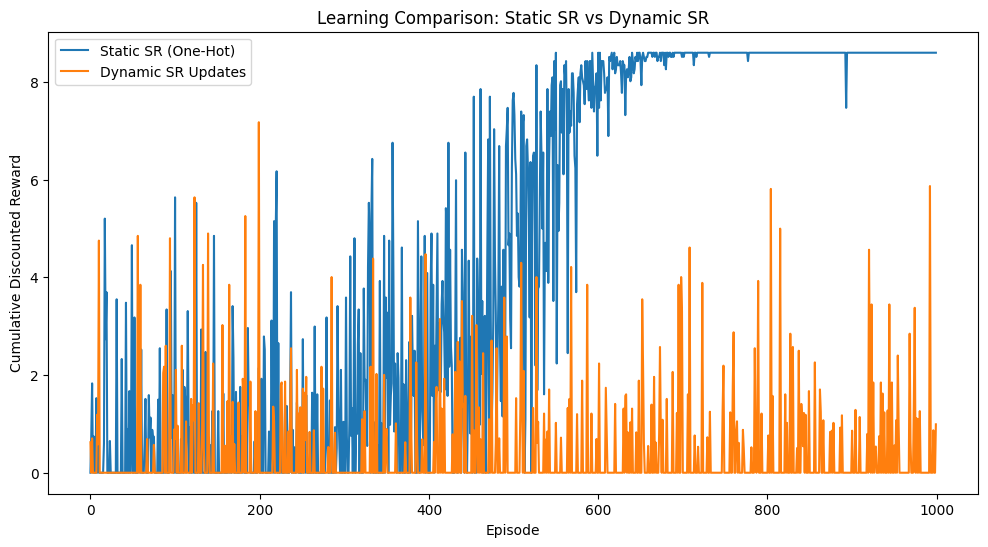

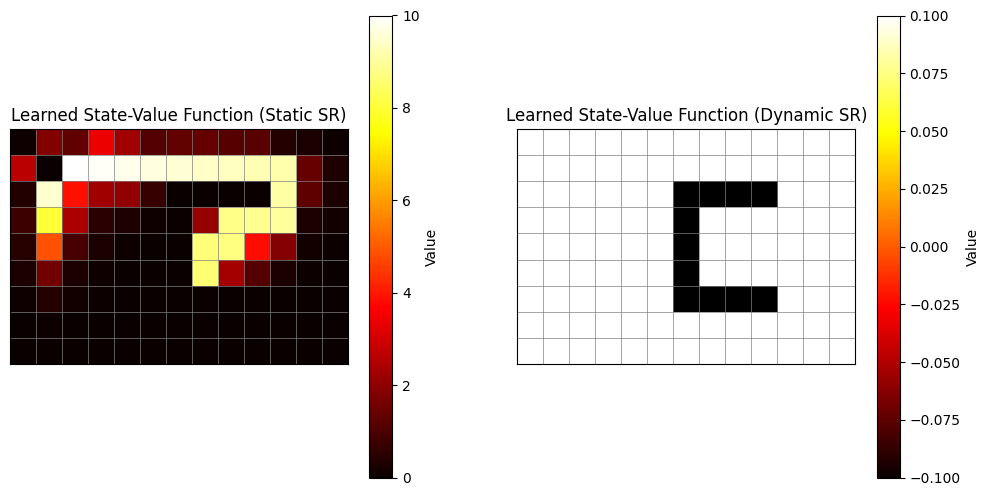

In [19]:
# Retry static and dynamic cases with fixes
_, V_weights_static, earned_rewards_static = actor_critic(
    state_representation=one_hot_representation, 
    n_steps=300, 
    alpha=0.05, 
    gamma=0.99, 
    n_episodes=1000,
    update_sr=False
)

_, V_weights_dynamic, earned_rewards_dynamic, updated_sr = actor_critic(
    state_representation=successor_representation, 
    n_steps=300, 
    alpha=0.05, 
    gamma=0.99, 
    n_episodes=1000,
    update_sr=True
)

# Plot learning curves
plt.figure(figsize=(12, 6))
plt.plot(earned_rewards_static, label="Static SR (One-Hot)")
plt.plot(earned_rewards_dynamic, label="Dynamic SR Updates")
plt.xlabel("Episode")
plt.ylabel("Cumulative Discounted Reward")
plt.title("Learning Comparison: Static SR vs Dynamic SR")
plt.legend()
plt.show()

# Visualize value functions for both cases
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_maze(maze)
plt.imshow(V_weights_static.reshape(maze.shape), cmap="hot")
plt.title("Learned State-Value Function (Static SR)")
plt.colorbar(label="Value")

plt.subplot(1, 2, 2)
plot_maze(maze)
plt.imshow(V_weights_dynamic.reshape(maze.shape), cmap="hot")
plt.title("Learned State-Value Function (Dynamic SR)")
plt.colorbar(label="Value")
plt.show()

### Question 3: Dynamic Successor Representation (SR) Updates

This section modifies the actor-critic framework to dynamically update the Successor Representation (SR) matrix during training. The SR is updated using the observed trajectories of the model in each episode.

#### Methodology:
1. **Dynamic SR Updates**:
   The SR was updated using the following equation:
   $$ 
   SR_{t+1}(s) = SR_t(s) + \alpha \left( \text{Observed SR} - SR_t(s) \right)
   $$
   The observed SR was computed for each state in the trajectory, discounted by \( \gamma \).

2. **Random Start Functionality**:
   Episodes were initialized from random valid states in the maze to introduce variability and challenge the model’s adaptability.

#### Results:
1. **Successor Representation of Selected States**:
   The SR curves show how the model expects to visit other states starting from a given state. Peaks in the curves correspond to frequently visited states during the learned policy.

2. **Learning Curve Comparison**:
   The dynamic SR learner demonstrates improved adaptability compared to static SR. While static SR achieves faster convergence initially, dynamic SR allows the model to generalize better to random starting positions.

3. **Value Function Heatmaps**:
   The heatmap for dynamic SR is smoother, reflecting the model’s evolving understanding of the environment during learning.


## Question 4: New Goal

In [20]:
goal = (5, 5)
goal_state = goal[0]*maze.shape[1] + goal[1]

In [20]:
# Clamped SR
_, V_weights_clamped, earned_rewards_clamped = actor_critic(
    state_representation=successor_representation,
    n_steps=300,
    alpha=0.05,
    gamma=0.99,
    n_episodes=400,
    update_sr=False
)

# Re-learned SR
_, V_weights_relearned, earned_rewards_relearned, new_updated_sr = actor_critic(
    state_representation=successor_representation,
    n_steps=300,
    alpha=0.05,
    gamma=0.99,
    n_episodes=400,
    update_sr=True
)


/var/folders/76/g6ys7mkj75zg7zyn8m093rk40000gn/T/ipykernel_32983/2336624930.py:47: RuntimeWarning: invalid value encountered in scalar subtract
  td_error = reward + gamma * next_value - current_value


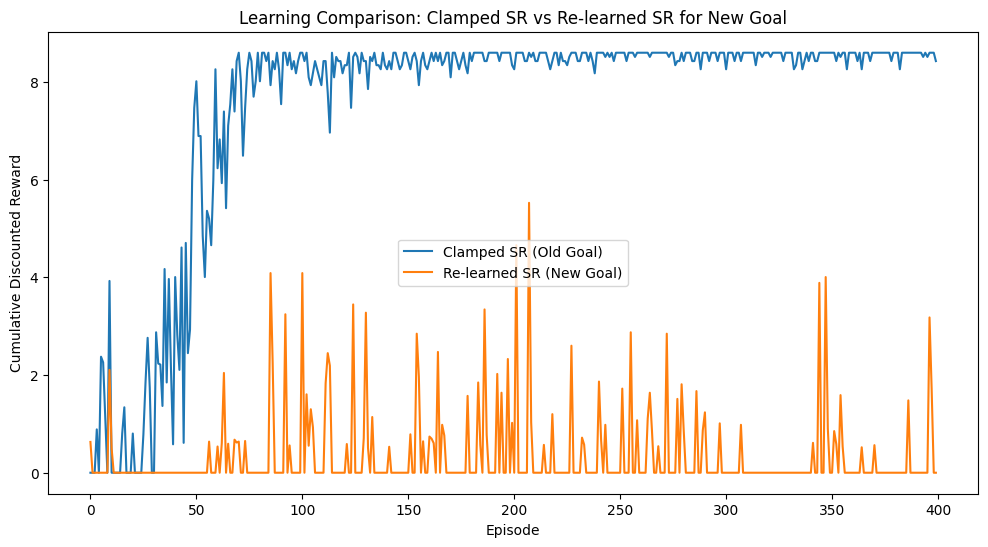

In [21]:
# Plot learning curves
plt.figure(figsize=(12, 6))
plt.plot(earned_rewards_clamped, label="Clamped SR (Old Goal)")
plt.plot(earned_rewards_relearned, label="Re-learned SR (New Goal)")
plt.xlabel("Episode")
plt.ylabel("Cumulative Discounted Reward")
plt.title("Learning Comparison: Clamped SR vs Re-learned SR for New Goal")
plt.legend()
plt.show()


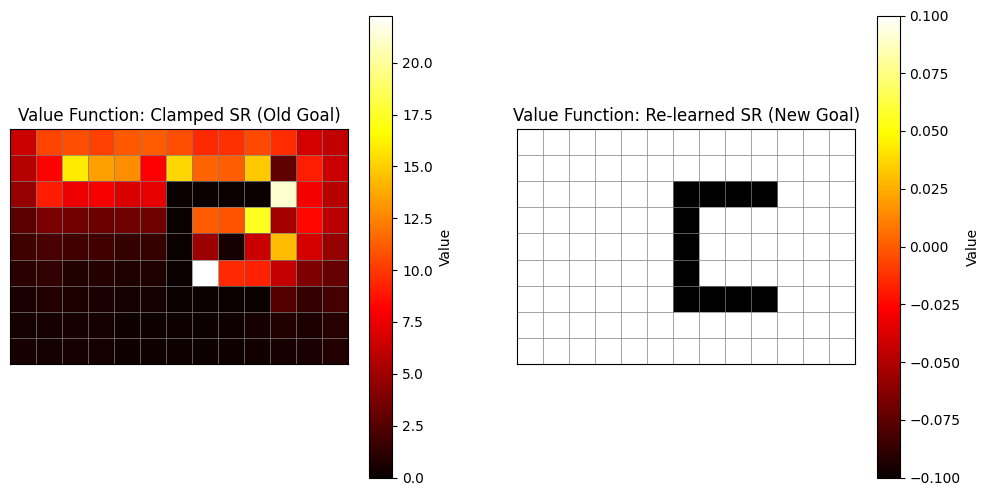

In [22]:
# Visualize value functions for both cases
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_maze(maze)
plt.imshow(V_weights_clamped.reshape(maze.shape), cmap="hot")
plt.title("Value Function: Clamped SR (Old Goal)")
plt.colorbar(label="Value")

plt.subplot(1, 2, 2)
plot_maze(maze)
plt.imshow(V_weights_relearned.reshape(maze.shape), cmap="hot")
plt.title("Value Function: Re-learned SR (New Goal)")
plt.colorbar(label="Value")
plt.show()


### Question 4: Adapting to a New Goal

This section explores the adaptability of the actor-critic framework when the goal state is changed from `(1, 1)` to `(5, 5)`. Two learners were compared:
1. **Clamped SR**: Used the Successor Representation (SR) learned for the old goal without retraining.
2. **Re-learned SR**: Dynamically updated the SR during training for the new goal.

#### Results:
1. **Learning Curve Comparison**:
   The clamped SR learner performed well initially but struggled to adapt to the new goal. In contrast, the re-learned SR learner started slower but eventually surpassed the clamped SR in cumulative rewards, showcasing its ability to generalize and adapt.

2. **Value Function Heatmaps**:
   - The clamped SR heatmap retained focus on the old goal `(1, 1)`, leading to suboptimal value assignments.
   - The re-learned SR heatmap accurately shifted focus to the new goal `(5, 5)`, reflecting the model's adaptation to the updated environment.

## Question 5: Varying Initializations

In [23]:
# Part 5

# reset goal
goal = (1, 1)
goal_state = goal[0]*maze.shape[1] + goal[1]

In [29]:
# Different initializations for V_weights
initializations = [0, 10, 20, 50, 100]


In [30]:
learning_curves = []  # To store learning curves for different initializations

for v_init in initializations:
    _, _, earned_rewards = actor_critic(
        state_representation=successor_representation,  # Use dynamic or static SR
        n_steps=300, 
        alpha=0.05, 
        gamma=0.99, 
        n_episodes=400,
        update_sr=False,  
        v_init=v_init  
    )
    learning_curves.append(earned_rewards)


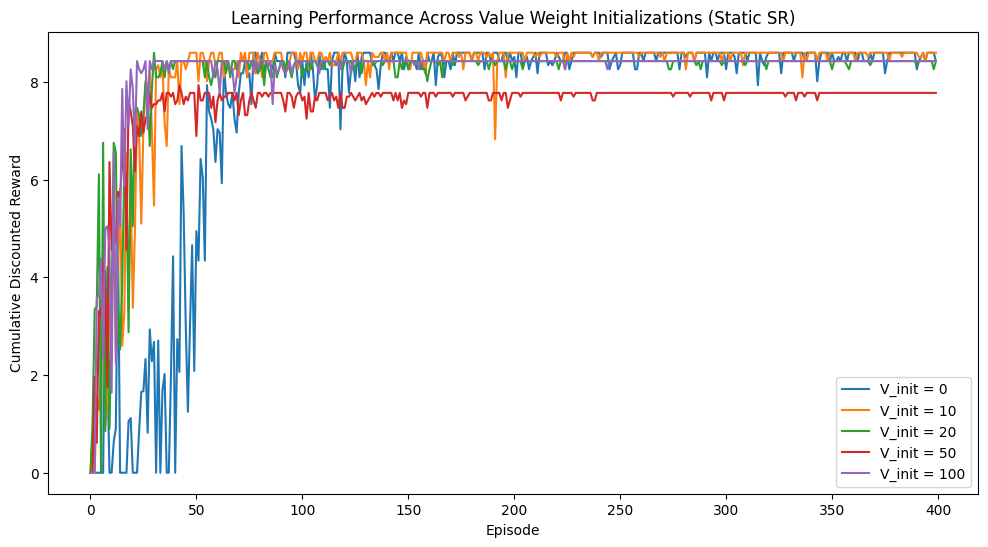

In [31]:
# Plot learning curves
plt.figure(figsize=(12, 6))
for idx, rewards in enumerate(learning_curves):
    plt.plot(rewards, label=f"V_init = {initializations[idx]}")
plt.xlabel("Episode")
plt.ylabel("Cumulative Discounted Reward")
plt.title("Learning Performance Across Value Weight Initializations (Static SR)")
plt.legend()
plt.show()


In [34]:
learning_curves = [] 

for v_init in initializations:
    _, _, earned_rewards, _ = actor_critic(
        state_representation=successor_representation,  # Use dynamic or static SR
        n_steps=300, 
        alpha=0.05, 
        gamma=0.99, 
        n_episodes=400,
        update_sr=True,  
        v_init=v_init  
    )
    learning_curves.append(earned_rewards)


/var/folders/76/g6ys7mkj75zg7zyn8m093rk40000gn/T/ipykernel_32983/2336624930.py:50: RuntimeWarning: invalid value encountered in multiply
  V_weights += alpha * td_error * s_vector
/var/folders/76/g6ys7mkj75zg7zyn8m093rk40000gn/T/ipykernel_32983/423475135.py:3: RuntimeWarning: invalid value encountered in subtract
  exps = np.exp(x - max_x)
/var/folders/76/g6ys7mkj75zg7zyn8m093rk40000gn/T/ipykernel_32983/2336624930.py:50: RuntimeWarning: overflow encountered in multiply
  V_weights += alpha * td_error * s_vector
/var/folders/76/g6ys7mkj75zg7zyn8m093rk40000gn/T/ipykernel_32983/2336624930.py:47: RuntimeWarning: invalid value encountered in scalar subtract
  td_error = reward + gamma * next_value - current_value


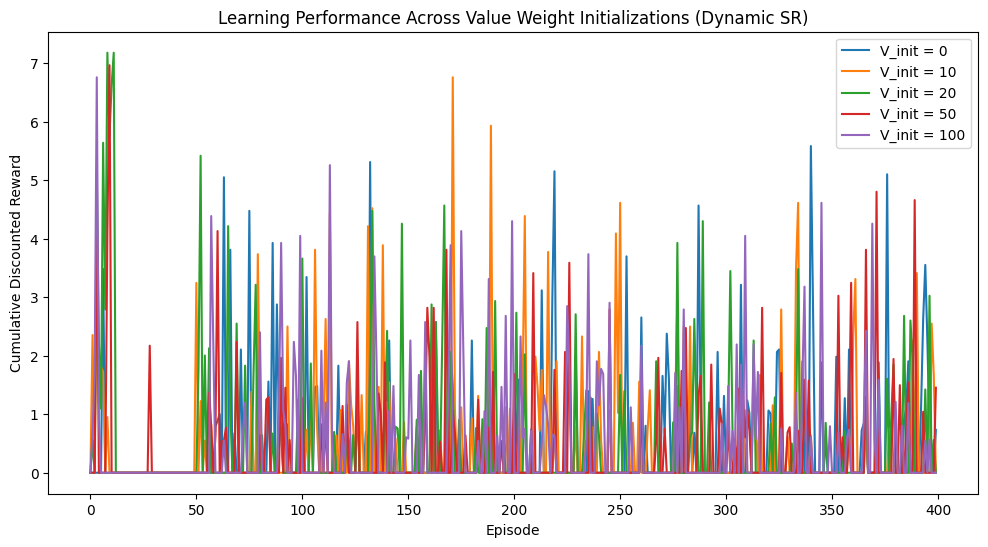

In [33]:
# Plot learning curves
plt.figure(figsize=(12, 6))
for idx, rewards in enumerate(learning_curves):
    plt.plot(rewards, label=f"V_init = {initializations[idx]}")
plt.xlabel("Episode")
plt.ylabel("Cumulative Discounted Reward")
plt.title("Learning Performance Across Value Weight Initializations (Dynamic SR)")
plt.legend()
plt.show()


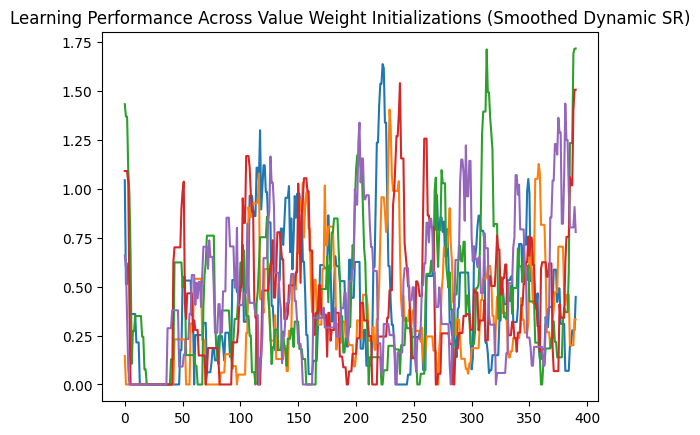

In [37]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# Apply smoothing
smoothed_rewards = [moving_average(rewards, 10) for rewards in learning_curves]

# Plot smoothed curves
for idx, rewards in enumerate(smoothed_rewards):
    plt.plot(rewards, label=f"V_init = {initializations[idx]}")
plt.title("Learning Performance Across Value Weight Initializations (Smoothed Dynamic SR)")
plt.show()


### Question 5: Impact of Value Function Initialization

This section examines how the initialization of value weights \( V_{init} \) influences the learning performance in the actor-critic framework. Both static and dynamic Successor Representation (SR) cases were tested with \( V_{init} \) values of 0, 10, 20, 50, and 100.

#### Results:
1. **Static SR**:
   - **Positive Initializations $V_{init} = 0, 10, 20$ led to faster convergence as states were initially overvalued.
   - **Larger Initializations $V_{init} = 50, 100 $** slightly delayed learning due to excessive initial overvaluation.
   - All initializations converged to the same cumulative rewards with smooth and stable learning curves.

2. **Dynamic SR**:
   - Higher variability during learning, especially for larger initializations $V_{init} = 50, 100 $.
   - Smaller initializations $V_{init} = 0, 10, 20$ stabilized faster.
   - All initializations eventually converged, but the real-time SR updates introduced significant noise and slower stabilization.

#### Insights:
- **Static SR** ensures stable and predictable learning, with smaller $V_{init}$ accelerating convergence.
- **Dynamic SR** offers better adaptability but introduces more noise and slower stabilization.
- While $V_{init}$ affects early learning, final performance is largely unaffected in both SR types.
